In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()

import os
import sys
import re
import pdb
import glob
import seaborn as sns

In [2]:
# Load clinical variant data
file_name = '../data/BRCAmut.xlsx'
clin_df = pd.read_excel(file_name, header=1)
brca2_seqs = clin_df.iloc[:,2:4]
brca1_seqs = clin_df.iloc[:,10:12]

brca2_df = pd.DataFrame(columns=['wt','ss'], data=brca2_seqs.as_matrix())
brca2_df['gene'] = 'BRCA2'
brca2_df

brca1_df = pd.DataFrame(columns=['wt','ss'], data=brca1_seqs.as_matrix())
brca1_df['gene'] = 'BRCA1'
brca1_df

ss_df = brca2_df.append(brca1_df)
ss_df['wt'] = (ss_df['wt']=='WT')
ss_df.dropna(inplace=True)
ss_df.head()

,wt,ss,gene
0,True,CAGGUAUUG,BRCA2
1,False,CAUGUAUUG,BRCA2
2,False,CAAGUAUUG,BRCA2
3,False,CAGGCAUUG,BRCA2
4,True,UAGGUAAGU,BRCA2


In [3]:
current_wt_ss = ''
wt_ss_list = []
for i, row in ss_df.iterrows():
    if row['wt']:
        current_wt_ss = row['ss']
    wt_ss_list.append(current_wt_ss)
ss_df['wt_ss'] = wt_ss_list
ss_df.head()

,wt,ss,gene,wt_ss
0,True,CAGGUAUUG,BRCA2,CAGGUAUUG
1,False,CAUGUAUUG,BRCA2,CAGGUAUUG
2,False,CAAGUAUUG,BRCA2,CAGGUAUUG
3,False,CAGGCAUUG,BRCA2,CAGGUAUUG
4,True,UAGGUAAGU,BRCA2,UAGGUAAGU


In [4]:
# Load library ratios
file_name = '../output/ratios_9nt_ss_lib.txt'
df = pd.read_csv(file_name, delim_whitespace=True, index_col='ss')

# Compute means, std, and rmse
new_df = pd.DataFrame(index=df.index)

loci = ['brca2_9nt', 'ikbkap_9nt', 'smn1_9nt']
for locus in loci:
    cols = [c for c in df.columns if locus in c]
    new_df[locus] = df[cols].mean(axis=1)
new_df.dropna(inplace=True)

new_df.loc['CAGGUAAGU',:]
new_df.loc[:,:] = 100*new_df.loc[:,:].as_matrix() / new_df.loc['CAGGUAAGU',:].as_matrix()
new_df.head()

new_df.loc['CAGGUAAGU',:]

brca2_9nt     100.0
ikbkap_9nt    100.0
smn1_9nt      100.0
Name: CAGGUAAGU, dtype: float64

In [5]:
seqs = np.array(ss_df['ss'])
wt_seqs = np.array(ss_df['wt_ss'])
for col in new_df.columns:
    ss_df[col+'_wt_psi'] = new_df.loc[wt_seqs,col].as_matrix()
    ss_df[col+'_mut_psi'] = new_df.loc[seqs,col].as_matrix()
ss_df = ss_df.loc[~ss_df['wt'],:]

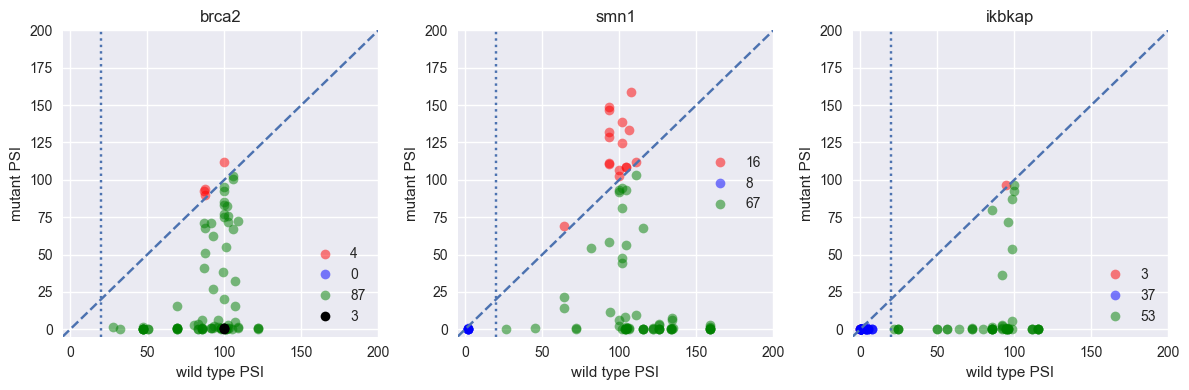

In [6]:
indices =  ~ss_df['wt'] 
fig, axs = plt.subplots(1,3,figsize=[12,4])
for i, locus in enumerate(['brca2', 'smn1', 'ikbkap']):
    ax = axs[i]
    xcol = locus+'_9nt_wt_psi'
    ycol = locus+'_9nt_mut_psi'
    indices
    x = ss_df.loc[indices,xcol]
    y = ss_df.loc[indices,ycol]
    red = y>=x
    blue = x < 20
    green = (~red) & (~blue)
    
    ax.plot(x[red],y[red],'or', alpha=.5, label=sum(red))
    ax.plot(x[blue],y[blue],'ob', alpha=.5, label=sum(blue))
    ax.plot(x[green],y[green],'og', alpha=.5, label=sum(green))
    
    if locus == 'brca2':
        black = ss_df['wt_ss']=='CAGGCAAGU'
        x_black = ss_df.loc[black,xcol]
        y_black = ss_df.loc[black,ycol]
        ax.plot(x_black,y_black,'ok', alpha=1, label=sum(black))
    
    lims = [-5,200]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.axvline(20,linestyle=':')
    ax.plot(lims,lims,'--')
    ax.set_xlabel('wild type PSI')
    ax.set_ylabel('mutant PSI')
    ax.legend()
    ax.set_title(locus)
fig.tight_layout()
fig.savefig('../plots/clinical_variants.pdf')